In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [209]:
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [210]:
class CFG:
    """
    Bu sınıf, veri setinin yüklenmesi ve ön işleme aşamaları için kullanılmıştır.
    Bazı hataları engellemek için sürekli kullanılan argümanlar bu sınıf içerisinde tanımlanmıştır.
    """
    train_path = "./data/train.csv"
    test_path = "./data/test_x.csv"
    target = "Öbek İsmi"
    reverse_obek_dict = {
    0: "obek_1",
    1: "obek_2",
    2: "obek_3",
    3: "obek_4",
    4: "obek_5",
    5: "obek_6",
    6: "obek_7",
    7: "obek_8",
    }
    obek_dict = {v:k for k, v in reverse_obek_dict.items()}
    # cat_cols ve num_cols listesi, grab_col_names() fonksiyonu ile bulunmuştur.
    cat_cols = ['Cinsiyet',
                'Yaş Grubu',
                'Medeni Durum',
                'Eğitim Düzeyi',
                'İstihdam Durumu',
                'Yaşadığı Şehir',
                'En Çok İlgilendiği Ürün Grubu',
                'Eğitime Devam Etme Durumu']
    num_cols = ['Yıllık Ortalama Gelir',
                'Yıllık Ortalama Satın Alım Miktarı',
                'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
                'Yıllık Ortalama Sepete Atılan Ürün Adedi']
    
    standardScaler = False
    minMaxScaler = False
    robustScaler = False

In [211]:
def one_hot_encoder(dataframe:pd.DataFrame, categorical_cols:list, drop_first=False) -> pd.DataFrame:
    """
    Verilen kategorik değişkenler için one-hot-encoding uygular.

    Args:
        dataframe (pd.DataFrame): İlgili veri seti.
        categorical_cols (list): Kategorik değişkenlerin listesi.
        drop_first (bool, optional): İlk kategorik değeri siler. Defaults to False.

    Returns:
        pd.DataFrame: One-hot encoding uygulanmış veri seti.
    """
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [212]:
def add_num_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Veri setine yeni nümerik özellikler ekler.

    Args:
        df (pd.DataFrame): İlgili veri seti.

    Returns:
        pd.DataFtrame: Yeni nümerik özellikler eklenmiş veri seti.
    """
    # Ortalama Gelir ve Ortalama Satın Alım Miktarı Oranı (Harcama Oranı)
    df["Harcama Oranı"] = df["Yıllık Ortalama Gelir"] / df["Yıllık Ortalama Satın Alım Miktarı"]
    # Ortalama Gelir ve Yıllık Ortalama Sepete Atılan Ürün Adedi Oranı
    df["Sepete Atma Oranı"] = df["Yıllık Ortalama Gelir"] / df["Yıllık Ortalama Sepete Atılan Ürün Adedi"]
    # Ortalama Gelir ve Yıllık Ortalama Sipariş Verilen Ürün Adedi Oranı
    df["Sipariş Verme Oranı"] = df["Yıllık Ortalama Gelir"] / df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    df["Sipariş Verme Oranı"] = df["Sipariş Verme Oranı"].apply(lambda x: 0 if x == np.inf else x)
    # Yıllık Ortalama Sipariş Verilen Ürün Adedi ve Yıllık Ortalama Sepete Atılan Ürün Adedi Oranı
    df["Sipariş Verme Adedi Oranı"] = df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] / df["Yıllık Ortalama Sepete Atılan Ürün Adedi"]
    # Yıllık Ortalama Sepete Atılan Ürün Adedi ve Yıllık Ortalama Sipariş Verilen Ürün Adedi Farkı
    df["Sepete Atma_Sipariş Verme Farkı"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] - df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    return df

In [213]:
def add_cat_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Veri setine yeni kategorik özellikler ekler.

    Args:
        df (pd.DataFrame): İlgili veri seti.

    Returns:
        pd.DataFtrame: Yeni kategorik özellikler eklenmiş veri seti.
    """
    # Yaş Grubu ve İstihdam Durumu Kombinasyonu
    df["Yaş Grubu İstihdam Durumu"] = df["Yaş Grubu"] + "_" + df["İstihdam Durumu"]
    # Yaş Grubu ve Eğitim Düzeyi Kombinasyonu
    df["Yaş Grubu Eğitim Düzeyi"] = df["Yaş Grubu"] + "_" + df["Eğitim Düzeyi"]
    # Yaş Grubu ve Medeni Durum Kombinasyonu
    df["Yaş Grubu Medeni Durum"] = df["Yaş Grubu"] + "_" + df["Medeni Durum"]
    # Eğitim Düzeyi ve İstihdam Durumu Kombinasyonu
    df['Egitim Istihdam'] = df['Eğitim Düzeyi'] + '_' + df['İstihdam Durumu']
    # Yaş Grubu ve En Çok İlgilendiği Ürün Grubu Kombinasyonu
    df['OrtalamaYas_IlgiGrubu'] = df['Yaş Grubu'] + '_' + df['En Çok İlgilendiği Ürün Grubu']
    # Eğitim ve Gelir İlişkisi
    df['Egitim_Gelir_Iliskisi'] = df['Eğitim Düzeyi'] + '_' + (df['Yıllık Ortalama Gelir'] // 100000).astype(str) + 'K'
    # Medeni Durum ve Sepete Atılan Ürün Adedi İlişkisi
    df['MedeniDurum_SepetAdedi'] = df['Medeni Durum'] + '_' + (df['Yıllık Ortalama Sepete Atılan Ürün Adedi'] // 10).astype(str) + 'A'
    # Cinsiyet ve Medeni Durum Kombinasyonu
    df["Cinsiyet_Medeni Durum"] = df["Cinsiyet"] + "_" + df["Medeni Durum"]
    # Şehir ve Yaş Grubu Kombinasyonu
    df["Şehir_Yaş Grubu"] = df["Yaşadığı Şehir"] + "_" + df["Yaş Grubu"]
    # Medeni Durum ve Eğitim Düzeyi Kombinasyonu
    df["Medeni Durum_Eğitim Düzeyi"] = df["Medeni Durum"] + "_" + df["Eğitim Düzeyi"]
    # İlgi Grubu ve Eğitim Düzeyi Kombinasyonu
    df["İlgi Grubu_Eğitim Düzeyi"] = df["En Çok İlgilendiği Ürün Grubu"] + "_" + df["Eğitim Düzeyi"]
    # Gelir Grubu
    bins = [0, 100000, 300000, 500000, 700000, 900000, float("inf")]
    bin_labels = ["0-100k", "100k-300k", "300k-500k", "500k-700k", "700k-900k", "900k+"]
    df["Gelir Grubu"] = pd.cut(df["Yıllık Ortalama Gelir"], bins=bins, labels=bin_labels)
    return df

In [214]:
def scale_data(df:pd.DataFrame, num_cols:list, scaler="standard") -> pd.DataFrame:
    """
    Veri setindeki nümerik değişkenleri ölçeklendirir.

    Args:
        df (pd.DataFrame): İlgili veri seti.
        num_cols (list): Nümerik değişkenlerin listesi.
        scaler (str, optional): Scaler cinsi. Defaults to "standard".

    Returns:
        pd.DataFrame: Ölçeklendirilmiş veri seti.
    """
    if scaler == "standard":
        CFG.standardScaler = True
    elif scaler == "minmax":
        CFG.minMaxScaler = True
    elif scaler == "robust":
        CFG.robustScaler = True
    if CFG.standardScaler:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])
    elif CFG.minMaxScaler:
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])
    elif CFG.robustScaler:
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])
        
    return df

In [215]:
def cat_summary(df:pd.DataFrame, col_name:str, plot=False):
    """
    Kategorik değişkenlerin sınıf sayılarını ve oranlarını gösterir.

    Args:
        df (pd.DataFrame): İlgili veri seti.
        col_name (str): Kategorik değişkenin adı.
        plot (bool, optional): Dağılımın grafiğini gösterir. Defaults to False.
    """
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))
    print(25 * "#")
    if plot:
        sns.countplot(x=df[col_name], data = df)
        plt.show()

In [216]:
def rare_analyser(df:pd.DataFrame, target:str, cat_cols:list):
    """
    Kategorik değişkenlerin sınıf sayılarını ve oranlarını hedef değişkene göre gösterir.

    Args:
        df (pd.DataFrame): İlgili veri seti.
        target (str): Hedef değişken.
        cat_cols (list): Kategorik değişkenlerin listesi.
    """
    for col in cat_cols:
        print(col, ":", len(df[col].value_counts()))
        print(pd.DataFrame({"COUNT": df[col].value_counts(),
                            "RATIO": df[col].value_counts() / df.shape[0],
                            "TARGET_MEAN": df.groupby(col)[target].mean()}), end="\n\n\n")

In [217]:
def rare_encoder(df:pd.DataFrame, rare_perc=0.01) -> pd.DataFrame:
    """
    Verilen eşik değerden daha az sınıfa sahip olan kategorik değişkenleri "Rare" olarak etiketler.

    Args:
        df (pd.DataFrame): İlgili veri seti.
        rare_perc (float, optional): Rare değişken olma eşiği. Defaults to 0.01.

    Returns:
        pd.DataFrame: Rare değişkenlerin etiketlendiği veri seti.
    """
    temp_df = df.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O"
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
                    
    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var])
    
    return temp_df

In [218]:
def make_submission(y_pred:np.array, test_df:pd.DataFrame) -> pd.DataFrame:
    """
    Test veri seti için tahminlerinizi göndermek için kullanılır.

    Args:
        y_pred (np.array): Tahminler.
        test_df (pd.DataFrame): Test veri seti.

    Returns:
        pd.DataFrame: Tahminlerinizi göndermek için kullanabileceğiniz veri seti.
    """
    submission = pd.DataFrame()
    submission["id"] = test_df["index"]
    submission["pred"] = y_pred
    submission[CFG.target] = submission["pred"].apply(lambda x: CFG.reverse_obek_dict[x])
    submission.drop("pred", axis=1, inplace=True)
    return submission

In [219]:
def grab_col_names(dataframe:pd.DataFrame, cat_th=10, car_th=20) -> tuple:
    """
    Veri setindeki kategorik, sayısal, kategorik ancak kardinal değişkenlerin listesini döndürür.

    Args:
        dataframe (pd.DataFrame): İlgili veri seti.
        cat_th (int, optional): Kategorik eşik değeri. Defaults to 10.
        car_th (int, optional): Cardinal eşik değeri. Defaults to 20.

    Returns:
        tuple: Kategorik, sayısal, kategorik ancak kardinal değişkenlerin listesi.
    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                    dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                    dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [220]:
def outlier_thresholds(df:pd.DataFrame, col_name:str, q1=0.25, q3=0.75) -> tuple:
    """
    Verilen değişken için alt ve üst eşik değerlerini döndürür.

    Args:
        df (pd.DataFrame): İlgili veri seti.
        col_name (str): Değişken adı.
        q1 (float, optional): 1. çeyrek değer. Defaults to 0.25.
        q3 (float, optional): 3. çeyrek değer. Defaults to 0.75.

    Returns:
        tuple: Alt ve üst eşik değerleri.
    """
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    up = quartile3 + 1.5 * iqr
    low = quartile1 - 1.5 * iqr
    return low, up

In [221]:
def check_outlier(df:pd.DataFrame, col_name:str) -> bool:
    """
    Verilen değişken için aykırı değer var mı yok mu kontrol eder.

    Args:
        df (pd.DataFrame): İlgili veri seti.
        col_name (str): Değişken adı.

    Returns:
        bool: Aykırı değer varsa True, yoksa False döndürür.
    """
    low, up = outlier_thresholds(df, col_name)
    return True if df[(df[col_name] > up) | (df[col_name] < low)].any(axis = None) else False

In [222]:
def grab_outliers(df:pd.DataFrame) -> pd.DataFrame:
    """
    Veri setindeki aykırı değerleri yakalar ve baskılar.
    Hedef değişkenin sınıflarına göre aykırı değerleri baskılar.

    Args:
        df (pd.DataFrame): İlgili veri seti.

    Returns:
        pd.DataFrame: Aykırı değerlerin baskılandığı veri seti.
    """
    obek_dfrms = []
    for i in range(len(CFG.obek_dict)):
        obek_dfrms.append(df[df[CFG.target] == i])
    for i, obek_df in enumerate(obek_dfrms):
        for col in CFG.num_cols:
            # print(f"Obek {i + 1} {col} Outlier Check: {check_outlier(obek_df, col)}")
            low, up = outlier_thresholds(obek_df, col)
            # print(f"Obek {i + 1} {col} Outlier Range: {low} - {up}")
            # Grab outliers 
            obek_dfrms[i] = obek_df[~((obek_df[col] < low) | (obek_df[col] > up))]
    return pd.concat(obek_dfrms, ignore_index=True)

# Verilerin Okunması

In [223]:
train_df = pd.read_csv(CFG.train_path)
test_df = pd.read_csv(CFG.test_path)
train_df[CFG.target] = train_df[CFG.target].apply(lambda x: CFG.obek_dict[x])
train_df["type"] = "train"
test_df["type"] = "test"

# EDA (Exploratory Data Analysis) - Veri Keşfi

In [224]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px

## Eksik Değer Analizi

In [225]:
train_df.isnull().sum()

index                                         0
Cinsiyet                                      0
Yaş Grubu                                     0
Medeni Durum                                  0
Eğitim Düzeyi                                 0
İstihdam Durumu                               0
Yıllık Ortalama Gelir                         0
Yaşadığı Şehir                                0
En Çok İlgilendiği Ürün Grubu                 0
Yıllık Ortalama Satın Alım Miktarı            0
Yıllık Ortalama Sipariş Verilen Ürün Adedi    0
Eğitime Devam Etme Durumu                     0
Öbek İsmi                                     0
Yıllık Ortalama Sepete Atılan Ürün Adedi      0
type                                          0
dtype: int64

In [226]:
test_df.isnull().sum()

index                                         0
Cinsiyet                                      0
Yaş Grubu                                     0
Medeni Durum                                  0
Eğitim Düzeyi                                 0
İstihdam Durumu                               0
Yıllık Ortalama Gelir                         0
Yaşadığı Şehir                                0
En Çok İlgilendiği Ürün Grubu                 0
Yıllık Ortalama Satın Alım Miktarı            0
Yıllık Ortalama Sipariş Verilen Ürün Adedi    0
Eğitime Devam Etme Durumu                     0
Yıllık Ortalama Sepete Atılan Ürün Adedi      0
type                                          0
dtype: int64

## Aykırı Değer Analizi

Benim daha önce yapmış olduğum denemeler sonucunda aykırı değer analizini ayrı ayrı feature ile yapmaktansa, ilgili feature'ları hedef değişkenin sınıflarına göre ayrı ayrı değerlendirme yapmak daha doğru sonuçlar verdiği için bu şekilde devam ettim. Bunların hepsini otomatik olarak yapacak olan `grab_outliers()` fonksiyonunu yazdım.

## Kategorik Değişken Analizi

       Cinsiyet      Ratio
Erkek      2964  54.285714
Kadın      2496  45.714286
#########################


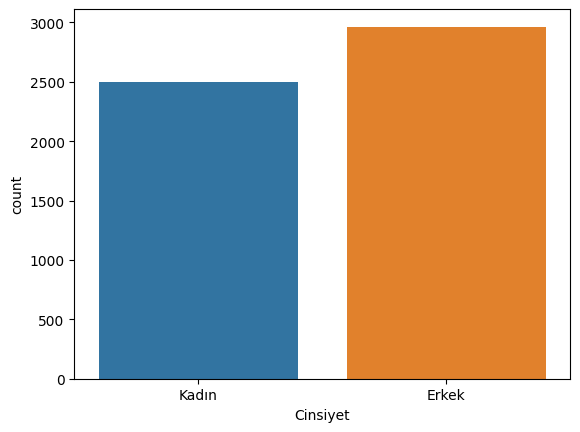

       Yaş Grubu      Ratio
18-30       1841  33.717949
31-40       1477  27.051282
51-60        861  15.769231
41-50        727  13.315018
>60          554  10.146520
#########################


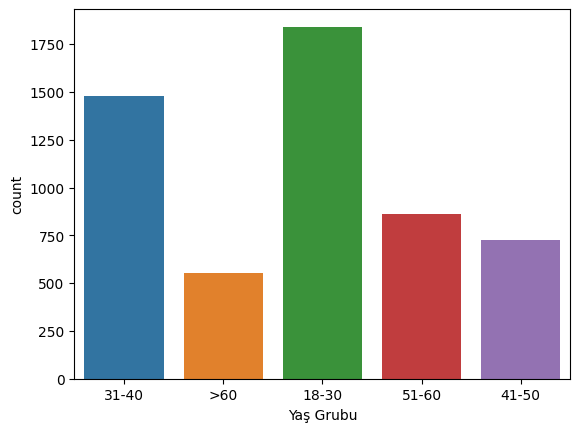

       Medeni Durum      Ratio
Evli           2834  51.904762
Bekar          2626  48.095238
#########################


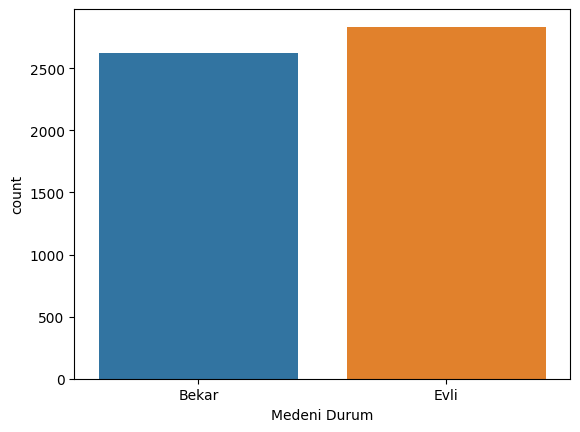

                      Eğitim Düzeyi      Ratio
Lise Mezunu                    1388  25.421245
Üniversite Mezunu              1257  23.021978
Yüksekokul Mezunu               588  10.769231
Yüksek Lisans Mezunu            545   9.981685
İlkokul Mezunu                  417   7.637363
Ortaokul Mezunu                 412   7.545788
Eğitimsiz                       381   6.978022
Doktora Mezunu                  263   4.816850
Doktora Ötesi                   209   3.827839
#########################


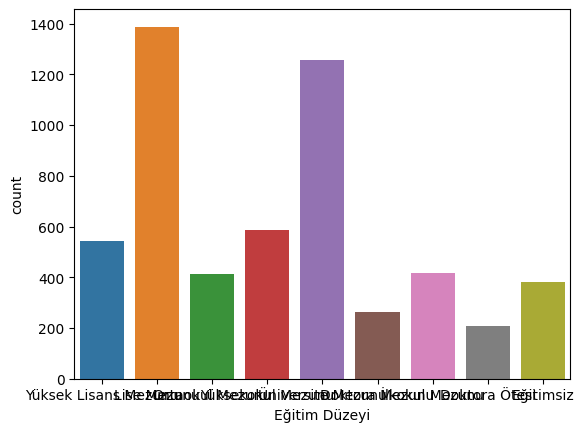

                                İstihdam Durumu      Ratio
Düzenli ve Ücretli Bir İşi Var             2768  50.695971
İşsiz veya Düzenli Bir İşi Yok             1349  24.706960
Kendi İşinin Sahibi                         879  16.098901
Emekli                                      464   8.498168
#########################


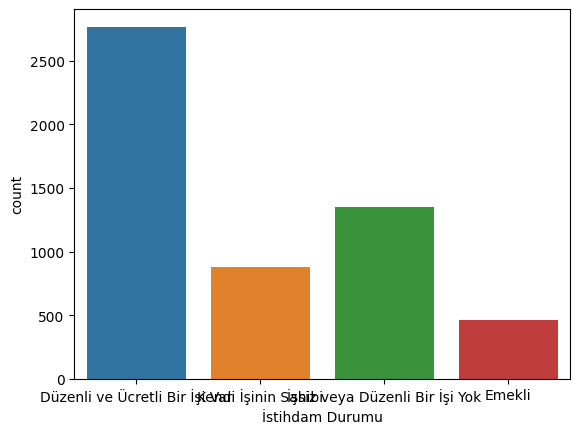

                 Yaşadığı Şehir      Ratio
Büyük Şehir                1959  35.879121
Küçük Şehir                1842  33.736264
Köy veya Kasaba            1092  20.000000
Kırsal                      567  10.384615
#########################


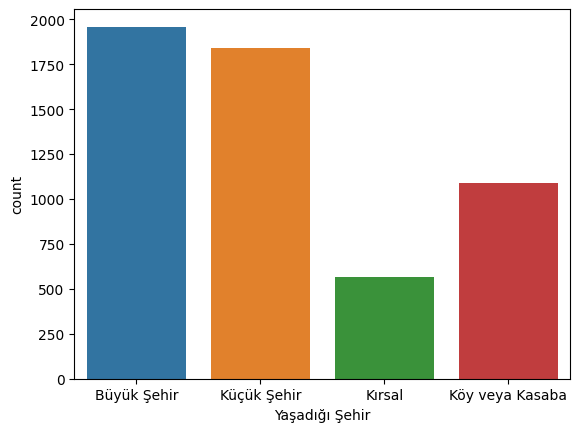

                                  En Çok İlgilendiği Ürün Grubu      Ratio
Giyim                                                      1487  27.234432
Ev ve Mobilya                                              1114  20.402930
Elektronik ve Teknolojik Ürünler                           1029  18.846154
Spor Malzemeleri                                           1001  18.333333
Kozmetik                                                    829  15.183150
#########################


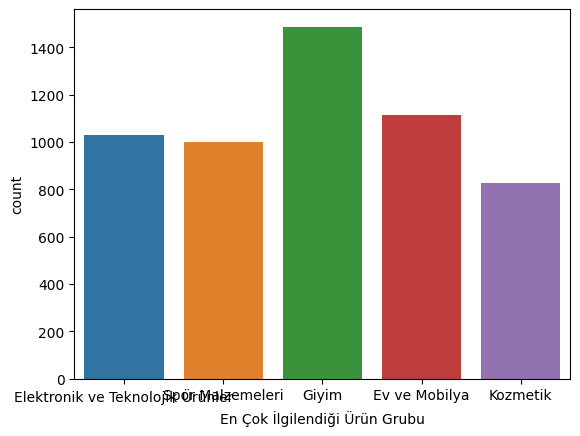

         Eğitime Devam Etme Durumu      Ratio
Etmiyor                       4554  83.406593
Ediyor                         906  16.593407
#########################


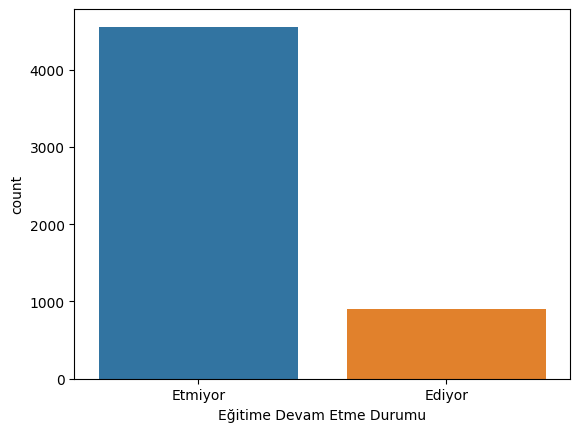

In [227]:
for col in CFG.cat_cols:
    cat_summary(train_df, col, plot=True)

## Az Rastlanan Verilerin(Rare) Analizi

In [228]:
rare_analyser(train_df, CFG.target, CFG.cat_cols)

Cinsiyet : 2
       COUNT     RATIO  TARGET_MEAN
Erkek   2964  0.542857     3.706478
Kadın   2496  0.457143     3.431090


Yaş Grubu : 5
       COUNT     RATIO  TARGET_MEAN
18-30   1841  0.337179     4.397067
31-40   1477  0.270513     3.268111
41-50    727  0.133150     2.955983
51-60    861  0.157692     3.217189
>60      554  0.101465     3.084838


Medeni Durum : 2
       COUNT     RATIO  TARGET_MEAN
Bekar   2626  0.480952     4.123001
Evli    2834  0.519048     3.077982


Eğitim Düzeyi : 9
                      COUNT     RATIO  TARGET_MEAN
Doktora Mezunu          263  0.048168     3.711027
Doktora Ötesi           209  0.038278     2.990431
Eğitimsiz               381  0.069780     1.658793
Lise Mezunu            1388  0.254212     3.282421
Ortaokul Mezunu         412  0.075458     1.941748
Yüksek Lisans Mezunu    545  0.099817     4.550459
Yüksekokul Mezunu       588  0.107692     4.557823
Üniversite Mezunu      1257  0.230220     4.760541
İlkokul Mezunu          417  0.076374    

## Kategorik Değişkenlerin Hedef Değişken İle İlişkisinin İncelenmesi

In [229]:
for col in CFG.cat_cols:
    fig = px.histogram(
        train_df, 
        x=col, 
        color=CFG.target, 
        barmode="group", 
        title=("{} ve Öbek").format(col)
        )
    fig.show()

## Sayısal Değişkenlerin Hedef Değişken ile İlişkilerinin İncelenmesi

In [230]:
for col in CFG.num_cols:
    fig = px.box(
        train_df,
        y=col,
        color=CFG.target, 
        title=("{} ve Öbek").format(col)
        )
    fig.show()

## Korelasyon Analizi

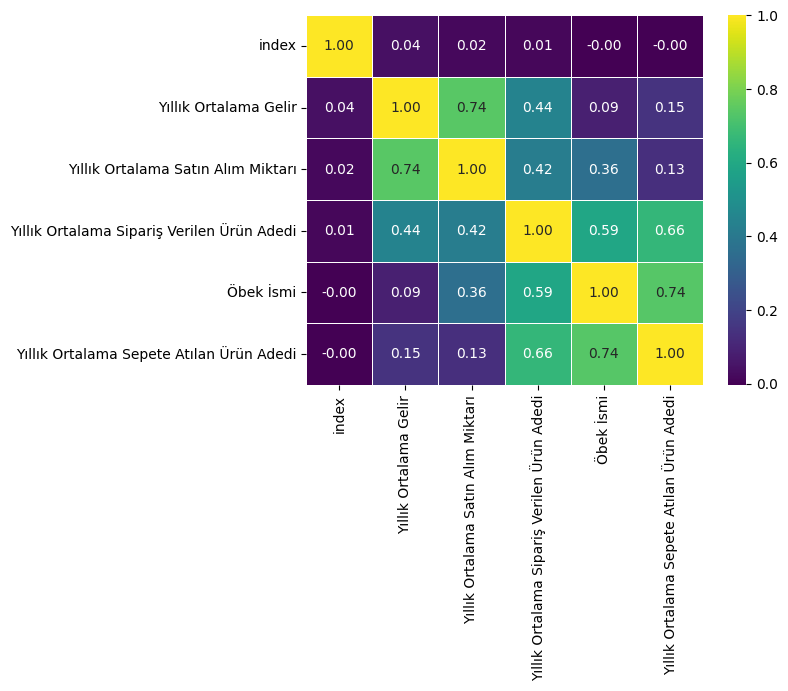

In [231]:
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", linewidths=0.5, cmap="viridis");

## Cinsiyet ve Eğitim Düzeyi İncelenmesi

In [232]:
fig = px.histogram(
    train_df,
    x="Cinsiyet",
    color="Eğitim Düzeyi",
    barmode="group",
    title="Cinsiyet ve Eğitim Düzeyi",
    category_orders=({"Yaş Grubu":(1,2,3,4,5)})
    )
fig.show()

## Yaş Grubu ve İstihdam Durumu İncelenmesi

In [233]:
fig = px.histogram(
    train_df,
    x="İstihdam Durumu",
    color="Yaş Grubu",
    barmode="group",
    title="Yaş Grubu ve İstihdam Durumu",
    category_orders=({"Yaş Grubu":(1,2,3,4,5)})
    )
fig.show()

## Öbek, Ortalama Gelir ve Cinsiyet İncelenmesi

In [234]:
fig = px.histogram(
    train_df,
    x="Öbek İsmi",
    y="Yıllık Ortalama Gelir",
    color="Cinsiyet",
    barmode="group",
    height=500,
    title = "Öbek, Ortalama Gelir ve Cinsiyet"
    )
fig.show()

## Cinsiyet, Yıllık Ortalama Sipariş Verilen Ürün Adedi ve En Çok ilgilendiği Ürün Grubu İncelenmesi

In [235]:
fig = px.histogram(
    train_df, 
    x="Cinsiyet", 
    y="Yıllık Ortalama Sipariş Verilen Ürün Adedi",
    color="En Çok İlgilendiği Ürün Grubu", 
    barmode="group",
    height=500,
    title="Cinsiyet, Yıllık Ortalama Sipariş Verilen Ürün Adedi ve En Çok ilgilendiği Ürün Grubu"
    )
fig.show()

## Yaş Grubu ve Eğitime Devam Etme Durumu İncelenmesi

In [236]:
fig = px.histogram(
    train_df,
    x="Eğitime Devam Etme Durumu",
    color="Yaş Grubu",
    barmode="group",
    title="Yaş Grubu ve Eğitime Devam Etme Durumu",
    category_orders=({"Yaş Grubu":(1,2,3,4,5)})
    )
fig.show()

## Cinsiyet ve Yaş Grubu İncelenmesi

In [237]:
fig = px.histogram(
    train_df,
    x="Cinsiyet", 
    color="Yaş Grubu",
    barmode="group",
    title="Cinsiyet ve Yaş Grubu",
    category_orders=({"Yaş Grubu":(1,2,3,4,5)})
    )
fig.show()

## Pairplot Analizi

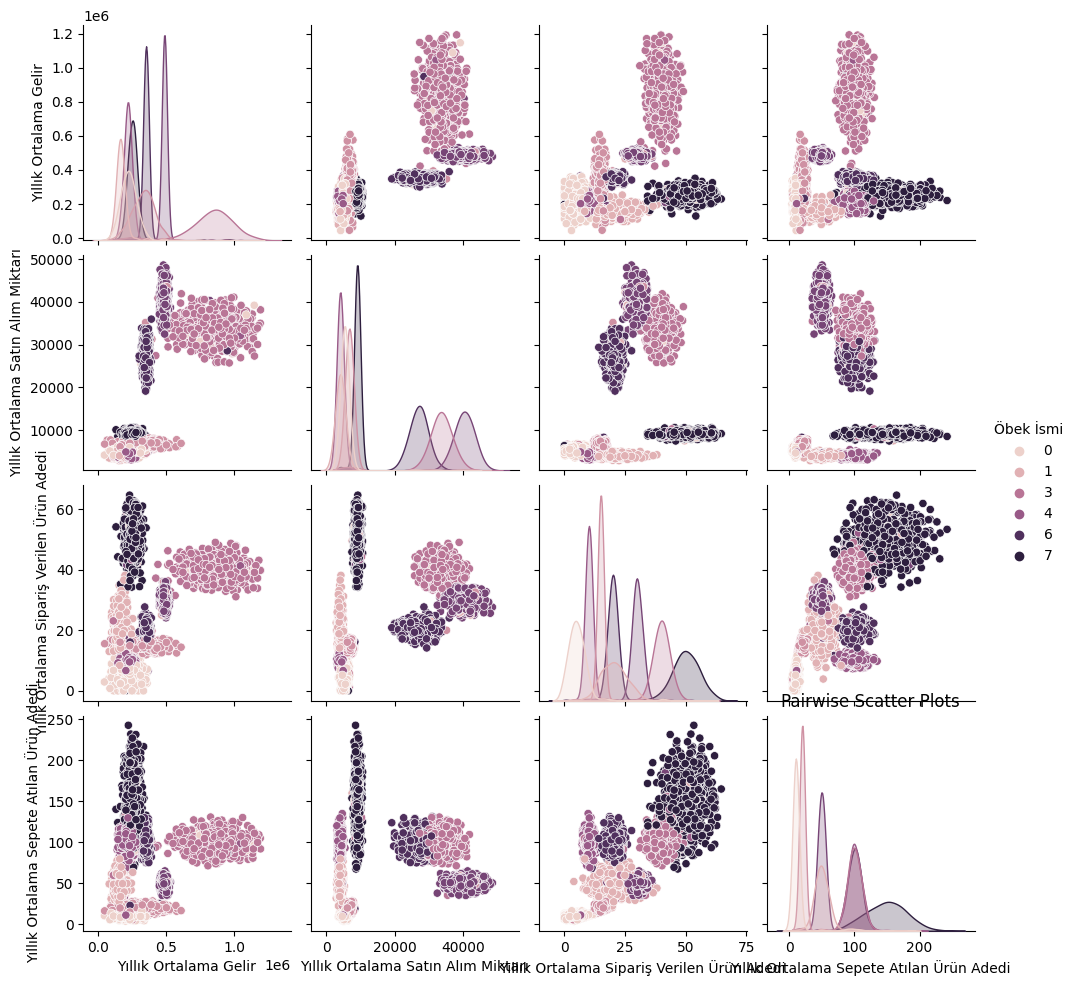

In [238]:
sns.pairplot(train_df.drop("index", axis=1), hue=CFG.target)
plt.title("Pairwise Scatter Plots")
plt.show()

## Mi Scores Analizi

Mi Score'u, bir değişkenin hedef değişken ile olan ilişkisini ölçen bir metriktir. Bu metriği kullanarak, hedef değişken ile en yüksek ilişkiye sahip olan değişkenleri seçebiliriz. Bu sayede modelimizin daha iyi sonuçlar vermesini sağlayabiliriz.

In [239]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

In [240]:
mi_scores_df = train_df.copy()
le = LabelEncoder()
for col in CFG.cat_cols:
    mi_scores_df[col] = le.fit_transform(mi_scores_df[col])

In [241]:
mi_scores = mutual_info_classif(mi_scores_df[mi_scores_df["type"] == "train"].drop(["type", "index", CFG.target], axis=1),
                                mi_scores_df[mi_scores_df["type"] == "train"][CFG.target])

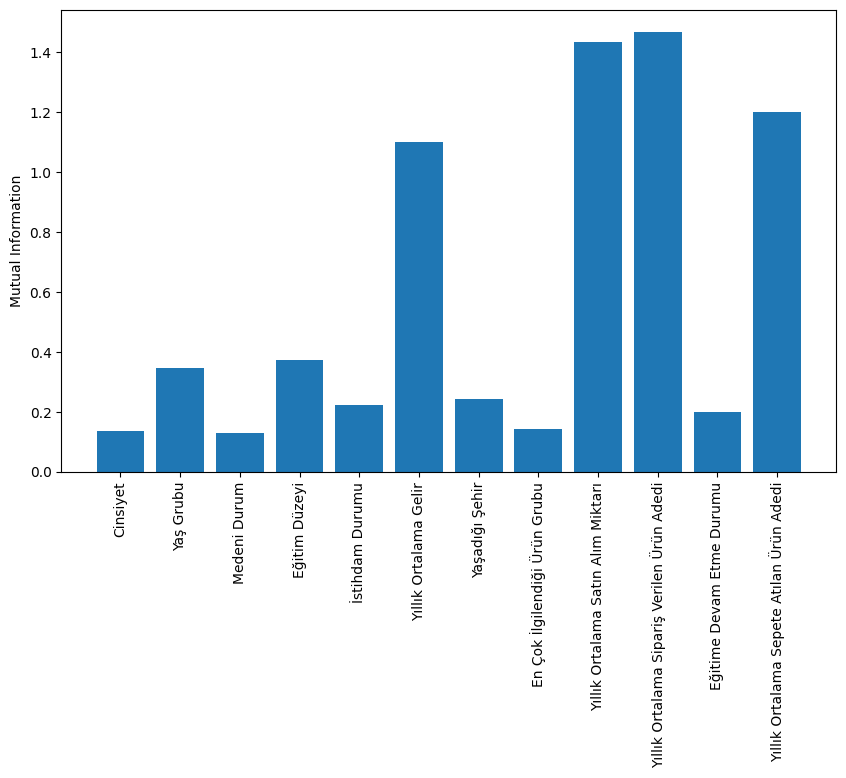

In [242]:
plt.figure(figsize=(10, 6))
plt.bar(mi_scores_df[mi_scores_df["type"] == "train"].drop(["type", "index", CFG.target], axis=1).columns, mi_scores)
plt.xticks(rotation=90)
plt.ylabel('Mutual Information')
plt.show()

# Veri Ön İşleme

In [243]:
# train veri setindeki aykırı değerleri baskıladık.
train_df = grab_outliers(train_df)
# train ve test veri setlerini birleştirdik.
df = pd.concat([train_df, test_df], ignore_index=True)

In [244]:
# Yeni Türettiğimiz Özellikleri Ekledik.
CFG.num_cols += ["Harcama Oranı", "Sipariş Verme Oranı", "Sepete Atma Oranı", "Sipariş Verme Adedi Oranı", "Sepete Atma_Sipariş Verme Farkı"]
CFG.cat_cols += ["Yaş Grubu İstihdam Durumu", "Yaş Grubu Eğitim Düzeyi", "Yaş Grubu Medeni Durum", "Egitim Istihdam", "OrtalamaYas_IlgiGrubu", "Egitim_Gelir_Iliskisi", "MedeniDurum_SepetAdedi",  "Gelir Grubu"]
CFG.cat_cols += ["Cinsiyet_Medeni Durum", "Şehir_Yaş Grubu", "Medeni Durum_Eğitim Düzeyi", "İlgi Grubu_Eğitim Düzeyi"]

In [245]:
# Veri setine yeni özellikler ekledik.
df = add_num_feature(df)
df = add_cat_features(df)
# Veri setindeki kategorik değişkenlere rare-encoding uyguladık.
df = rare_encoder(df, rare_perc=0.02)
# Veri setindeki nümerik değişkenleri ölçeklendirdik.
df = scale_data(df, CFG.num_cols, scaler="robust")
# Veri setindeki kategorik değişkenleri one-hot-encoding uyguladık.
df = one_hot_encoder(df, CFG.cat_cols, drop_first=True)

In [246]:
df.head()

index  Yıllık Ortalama Gelir  Yıllık Ortalama Satın Alım Miktarı  \
0     11               0.103678                           -0.124186   
1     33              -0.347525                           -0.086801   
2     43              -0.237452                           -0.130322   
3     75              -0.363282                           -0.086953   
4     76              -0.358933                           -0.134857   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi  Öbek İsmi  \
0                                   -0.735733        0.0   
1                                   -0.613646        0.0   
2                                   -0.685711        0.0   
3                                   -0.586367        0.0   
4                                   -0.776137        0.0   

   Yıllık Ortalama Sepete Atılan Ürün Adedi   type  Harcama Oranı  \
0                                 -0.935192  train       0.997449   
1                                 -0.897780  train       0.069151   
2                                 -0.956105  train       0.490706   
3                                 -0.914550  train       0.048316   
4                                 -0.929160  train       0.318469   

   Sepete Atma Oranı  Sipariş Verme Oranı  Sipariş Verme Adedi Oranı  \
0           3.659993            11.714180                  -0.188830   
1           1.297974             2.046031                   0.289048   
2           3.258998             4.742455                   0.520447   
3           1.529782             1.542026                   0.646660   
4           1.851442            11.805041                  -0.535077   

   Sepete Atma_Sipariş Verme Farkı  Cinsiyet_Kadın  Yaş Grubu_31-40  \
0                        -0.575672               0                0   
1                        -0.575312               0                0   
2                        -0.615156               1                0   
3                        -0.602711               0                0   
4                        -0.555655               0                0   

   Yaş Grubu_41-50  Yaş Grubu_51-60  Yaş Grubu_>60  Medeni Durum_Evli  \
0                1                0              0                  1   
1                0                1              0                  0   
2                0                0              0                  0   
3                0                1              0                  1   
4                1                0              0                  1   

   Eğitim Düzeyi_Doktora Ötesi  Eğitim Düzeyi_Eğitimsiz  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        1   

   Eğitim Düzeyi_Lise Mezunu  Eğitim Düzeyi_Ortaokul Mezunu  \
0                          0                              0   
1                          0                              1   
2                          1                              0   
3                          1                              0   
4                          0                              0   

   Eğitim Düzeyi_Yüksek Lisans Mezunu  Eğitim Düzeyi_Yüksekokul Mezunu  \
0                                   0                                1   
1                                   0                                0   
2                                   0                                0   
3                                   0                                0   
4                                   0                                0   

   Eğitim Düzeyi_Üniversite Mezunu  Eğitim Düzeyi_İlkokul Mezunu  \
0                                0                             0   
1                                0                             0   
2                                0                             0   
3                                0                

In [247]:
# Veri setini train ve test olarak ayırdık.
X = df[df["type"] == "train"].drop(["type", "index", CFG.target], axis=1)
y = df[df["type"] == "train"][CFG.target]
X_test_real = df[df["type"] == "test"].drop(["type", "index", CFG.target], axis=1)

## TSNE Analizi

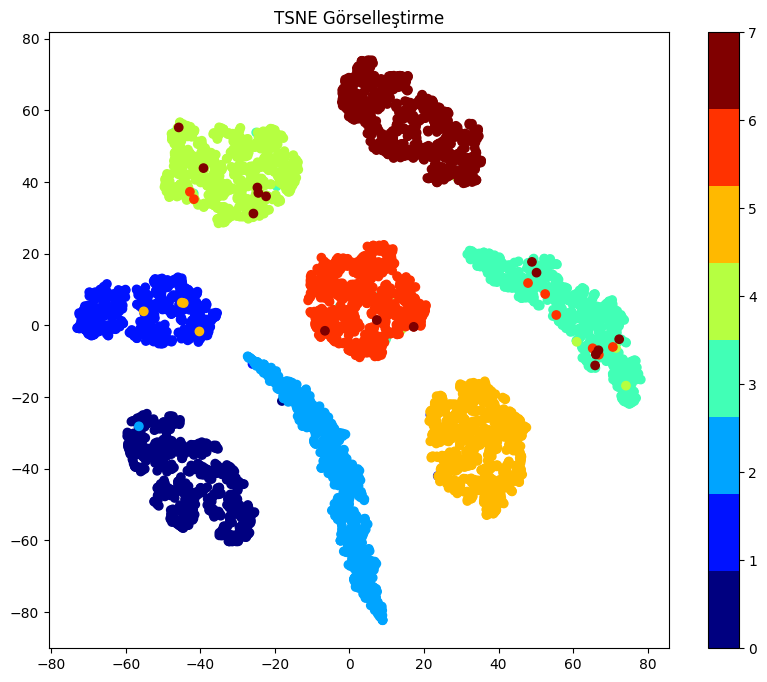

In [248]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X_tsne = tsne.fit_transform(X[['Yıllık Ortalama Gelir',
                                'Yıllık Ortalama Satın Alım Miktarı',
                                'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
                                'Yıllık Ortalama Sepete Atılan Ürün Adedi']])
# Görselleştirme
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.get_cmap("jet", len(np.unique(y.astype(int)))))
plt.colorbar(scatter, ticks=np.unique(y))
plt.title("TSNE Görselleştirme")
plt.show()

# Modelleme

In [255]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [250]:
clf_list = [RandomForestClassifier(),
            LogisticRegression(),
            LGBMClassifier(),
            XGBClassifier(),
            CatBoostClassifier(verbose=False)]

Model seçimi yaparken cross validation yaparak en iyi sonuç veren modeli seçtim. 

In [251]:
for clf in clf_list:
    cv_scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    print("-" * 50)
    print(clf.__class__.__name__)
    print("CV Accuracy Scores: ", cv_scores)
    print("CV Accuracy Mean: ", cv_scores.mean())

--------------------------------------------------
RandomForestClassifier
CV Accuracy Scores:  [0.9828408  0.98760724 0.99714013 0.98951382 0.98664122]
CV Accuracy Mean:  0.9887486446561246
--------------------------------------------------
LogisticRegression
CV Accuracy Scores:  [0.97807436 0.98379409 0.99332698 0.98379409 0.98187023]
CV Accuracy Mean:  0.9841719485660644
--------------------------------------------------
LGBMClassifier
CV Accuracy Scores:  [0.9828408  0.98665396 0.99618684 0.98856053 0.98664122]
CV Accuracy Mean:  0.9881766713482124
--------------------------------------------------
XGBClassifier
CV Accuracy Scores:  [0.9828408  0.98474738 0.99523356 0.98665396 0.98568702]
CV Accuracy Mean:  0.9870325428070353
--------------------------------------------------
CatBoostClassifier
CV Accuracy Scores:  [0.9828408  0.98760724 0.99714013 0.98856053 0.98664122]
CV Accuracy Mean:  0.9885579868868206


Model olarak CatBoostClassifier'ı seçtim. Hiper parametre optimizasyonunu başka not defterinde uyguladım fakat sonuçta değişiklik elde edemeyince varsayılan parametreler ile devam ettim.

In [252]:
model = CatBoostClassifier(verbose=False)
model.fit(X, y)

In [256]:
train_pred = model.predict(X)
print("Train Accuracy: ", accuracy_score(y, train_pred))

Train Accuracy:  0.9992372234935164


In [257]:
y_pred = model.predict(X_test_real)

# Submission

In [258]:
submission = make_submission(y_pred, test_df)

In [259]:
submission.to_csv("submission.csv", index=False)